In [1]:
#  In production mode we just load the best model and don't train it
# DEBUG_MODE = not(PRODUCTION_MODE)
PRODUCTION_MODE = True

In [2]:
# load the best transformer 
!gdown --id '1RQFMi-Nl4vbWyxzpmGB4k4kToyA5jzCh'

Downloading...
From: https://drive.google.com/uc?id=1RQFMi-Nl4vbWyxzpmGB4k4kToyA5jzCh
To: /content/trans_seq2seq_trainable_TRUE-004--0.283362.h5
100% 57.6M/57.6M [00:00<00:00, 163MB/s]


## Setup

In [4]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

## Preparing the data

In [5]:
import pandas as pd
import re

def preprocess_sentence(sentence, max_len= 40):
  sentence = sentence.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # removing contractions
  sentence = re.sub(r"i'm", "i am", sentence)
  sentence = re.sub(r"he's", "he is", sentence)
  sentence = re.sub(r"she's", "she is", sentence)
  sentence = re.sub(r"it's", "it is", sentence)
  sentence = re.sub(r"that's", "that is", sentence)
  sentence = re.sub(r"what's", "what is", sentence)
  sentence = re.sub(r"where's", "where is", sentence)
  sentence = re.sub(r"how's", "how is", sentence)
  sentence = re.sub(r"\'ll", " will", sentence)
  sentence = re.sub(r"\'ve", " have", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"\'d", " would", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"won't", "will not", sentence)
  sentence = re.sub(r"can't", "cannot", sentence)
  sentence = re.sub(r"n't", " not", sentence)
  sentence = re.sub(r"n'", "ng", sentence)
  sentence = re.sub(r"'bout", "about", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  # remove extra spaces  " hi     man  " --> " hi man "
  sentence = re.sub(' +', ' ', sentence)
  sentence = sentence.strip()
  sentence = ' '.join(sentence.split(' ')[:max_len])
  return sentence


In [6]:
!gdown --id 1DeItE4GAV1sF_39aYxAz9qijZFJpfVYE # train set

Downloading...
From: https://drive.google.com/uc?id=1DeItE4GAV1sF_39aYxAz9qijZFJpfVYE
To: /content/dialogues_train.txt
100% 6.04M/6.04M [00:00<00:00, 79.8MB/s]


In [7]:
!gdown --id 1zIyapuv4_EHhPPqj9EHXy9XyigOssNvA # test/holdout set

Downloading...
From: https://drive.google.com/uc?id=1zIyapuv4_EHhPPqj9EHXy9XyigOssNvA
To: /content/dialogues_test.txt
100% 544k/544k [00:00<00:00, 133MB/s]


In [8]:
!gdown --id 1mGQGsFRV7cR4SuNddHSI5imYAJkgDjpo # val/dev

Downloading...
From: https://drive.google.com/uc?id=1mGQGsFRV7cR4SuNddHSI5imYAJkgDjpo
To: /content/dialogues_validation.txt
100% 558k/558k [00:00<00:00, 108MB/s]


In [9]:
def read_dataset(path, max_records = 0):
  text = []


  with open(path, 'r') as f:
    for line in f:
      line = line.rstrip()
      # print(line)
      res = line.split('__eou__')

      for i in range(0, len(res)-2):
        sent_1 = preprocess_sentence(res[i], max_len= 40)
        sent_2 = preprocess_sentence(res[i+1], max_len= 38)
        text.append(sent_1)
        text.append("[start] " + sent_2 + " [end]")
        if max_records > 0 and len(text) == max_records:
          return text

  return text


In [10]:

train_text = read_dataset('dialogues_train.txt' , max_records = 5000)
test_text = read_dataset('dialogues_test.txt', max_records = 5000)
valid_text = read_dataset('dialogues_validation.txt', max_records = 5000)

In [11]:
dataset = train_text + test_text + valid_text

In [12]:
len(train_text)

5000

In [13]:
index = len(train_text)
train_input = [train_text[i] for i in range(0,index) if i % 2 == 0]
train_output = [train_text[i] for i in range(0,index) if i % 2 == 1]
train_pairs = [(train, test) for train, test in zip(train_input, train_output)]

In [14]:
next(zip(train_input, train_output)) 

('say , jim , how about going for a few beers after dinner ?',
 '[start] you know that is tempting but is really not good for our fitness . [end]')

In [15]:
max([len(x.split(' ')) for x in train_input]), max([len(x.split(' ')) for x in train_output])

(40, 40)

In [16]:
index = len(test_text)
test_input = [test_text[i] for i in range(0,index) if i % 2 == 0]
test_output = [test_text[i] for i in range(0,index) if i % 2 == 1]
test_pairs = [(train, test) for train, test in zip(test_input, test_output)]

In [17]:
index = len(valid_text)
val_input = [valid_text[i] for i in range(0,index) if i % 2 == 0]
val_output = [valid_text[i] for i in range(0,index) if i % 2 == 1]
val_pairs = [(train, test) for train, test in zip(val_input, val_output)]

## Vectorizing the text data

We'll use a instance of the `TextVectorization` layer to vectorize the text
data,
that is to say, to turn the original strings into integer sequences
where each integer represents the index of a word in a vocabulary.

We use the default string standardization (strip punctuation characters)
and splitting scheme (split on whitespace).



In [18]:
vocab_size = 6000
sequence_length = 40
batch_size = 64

p = string.punctuation
enc_strip = p.replace("?",
                      "").replace("!", "").replace(".", "").replace(",", "")

p = string.punctuation
dec_strip = p.replace("[", "").replace("]",
        "").replace("?", "").replace("!", "").replace(".", "").replace(",", "")

def enc_custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(enc_strip), "")

enc_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
    standardize = enc_custom_standardization
)



def dec_custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(dec_strip), "")

dec_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length+1,
    standardize=dec_custom_standardization,
)

index = len(dataset)
inp_texts = [dataset[i] for i in range(0,index) if i % 2 == 0]
out_texts = [dataset[i] for i in range(0,index) if i % 2 == 1]


enc_vectorization.adapt(inp_texts)
dec_vectorization.adapt(out_texts)


In [19]:
enc_vectorization.vocabulary_size(), len(enc_vectorization.get_vocabulary())

(6000, 6000)

In [20]:
dec_vectorization.vocabulary_size(), len(dec_vectorization.get_vocabulary())

(6000, 6000)

In [21]:
enc_vectorization.get_vocabulary()[:10]

['', '[UNK]', '.', ',', 'i', 'you', '?', 'the', 'to', 'a']

In [22]:
# manipulate the dataset to suit our manually fixed vacab_size (=6000)
# and our [UNK] token
# In other words, we are going to replace all words out of our 6000 
# defined vocab list and then feed this corpus to our model.

In [23]:
def modifier(list_of_sentences, vocab, vectorizer):
  sentences = list_of_sentences.copy()
  for i in range(len(sentences)):
    token_ids = vectorizer(sentences[i]).numpy()
    split = sentences[i].split(' ')
    if len(token_ids) < len(split):
      print('The string is empty')
      print(i,sentences[i])
      break
    for j in range(len(split)):
      split[j] = vocab[token_ids[j]]
    
    # len of split and non-pad tokens should be equal
    if len(token_ids) > len(split) and token_ids[len(split)] !=0:
      print(f'an error happened for {sentences[i]}')
    sentences[i] = split

  return sentences


enc_vocab = enc_vectorization.get_vocabulary()
dec_vocab = dec_vectorization.get_vocabulary()
# modifiend and tokenized text
modified_inp_texts = modifier(inp_texts,
                              enc_vocab,
                              enc_vectorization)
modified_out_texts = modifier(out_texts,
                              dec_vocab,
                              dec_vectorization)

In [24]:
# Calculating W2V embedding wieghts for both 
# encoder-embedding and decoder-embedding parts
from gensim.models.word2vec import Word2Vec
from multiprocessing import cpu_count
cores = cpu_count()

embedding_dim = 300


enc_w2v = Word2Vec(
    size = embedding_dim,
    window = 10,
    min_count = 1,
    workers = cores,
    sg = 1
)

dec_w2v = Word2Vec(
    size = embedding_dim,
    window = 10,
    min_count = 1,
    workers = cores,
    sg = 1
)

# we don't pass the first elemnt, padding token. we set its embedding zero
enc_w2v.build_vocab([enc_vectorization.get_vocabulary()[1:]])

enc_w2v.train(
    sentences = modified_inp_texts,
    total_examples = len(modified_inp_texts),
    epochs = enc_w2v.epochs )

# we don't pass the first elemnt, padding token. we set its embedding zero
dec_w2v.build_vocab([dec_vectorization.get_vocabulary()[1:]])

dec_w2v.train(
    sentences = modified_out_texts,
    total_examples = len(modified_out_texts),
    epochs = dec_w2v.epochs )

(596230, 596230)

In [25]:
set(enc_vocab)- set(enc_w2v.wv.vocab.keys()) , set(enc_w2v.wv.vocab.keys()) - set(enc_vocab) \
, len(enc_vocab), len(enc_w2v.wv.vocab.keys())

({''}, set(), 6000, 5999)

In [26]:
set(dec_vocab)- set(dec_w2v.wv.vocab.keys()) , set(dec_w2v.wv.vocab.keys()) - set(dec_vocab) \
, len(dec_vocab), len(dec_w2v.wv.vocab.keys())

({''}, set(), 6000, 5999)

In [27]:
tt = 'say , jim , how about going for a few beers after dinner ?'
enc_vectorization(tt)

<tf.Tensor: shape=(40,), dtype=int64, numpy=
array([ 138,    3,  648,    3,   37,   41,   80,   18,    9,  180, 2396,
        164,  477,    6,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])>

In [28]:
dec_w2v.wv['[UNK]'].reshape(1, -1)[0].shape

(300,)

In [29]:
def embedding_matrix_maker(voc_s, emb_s,w2v_model,vocab_list):
  """
  note1: fist element of vocab list is '', which is our padding token
  and should have a zero vector as its embedding 
  """
  weights = np.zeros((voc_s, emb_s))
  for i in range(1,len(vocab_list)) :
    weights[i] = w2v_model.wv[vocab_list[i]].reshape(1, -1)[0]
    
  return weights 

In [30]:
enc_embed_weights = embedding_matrix_maker(vocab_size,
                                           embedding_dim,
                                           enc_w2v,
                                           enc_vocab)


dec_embed_weights = embedding_matrix_maker(vocab_size,
                                           embedding_dim,
                                           dec_w2v,
                                           dec_vocab)

## Decoder input:


Next, we'll format our datasets.

At each training step, the model will seek to predict target words N+1 (and beyond)
using the source sentence and the target words 0 to N.

As such, the training dataset will yield a tuple `(inputs, targets)`, where:

- `inputs` is a dictionary with the keys `encoder_inputs` and `decoder_inputs`.
`encoder_inputs` is the vectorized source sentence and `encoder_inputs` is the target sentence "so far",
that is to say, the words 0 to N used to predict word N+1 (and beyond) in the target sentence.
- `target` is the target sentence offset by one step:
it provides the next words in the target sentence -- what the model will try to predict.

In [31]:
def format_dataset(inp, out):
    inp = enc_vectorization(inp)
    out = dec_vectorization(out)
    return ({"encoder_inputs": inp, "decoder_inputs": out[:, :-1],}, out[:, 1:])


def make_dataset(pairs):
    inp_texts, out_texts = zip(*pairs)
    inp_texts = list(inp_texts)
    out_texts = list(out_texts)
    dataset = tf.data.Dataset.from_tensor_slices((inp_texts, out_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)
test_ds = make_dataset(test_pairs)

In [32]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.CacheDataset

Let's take a quick look at the sequence shapes
(we have batches of 64 pairs, and all sequences are 40 steps long):

In [33]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 40)
inputs["decoder_inputs"].shape: (64, 40)
targets.shape: (64, 40)


## Building the model




In [34]:
from tensorflow.keras.initializers import Constant 
from tensorflow.keras.layers import Embedding


In [35]:

embedding_layer7 = Embedding(
    vocab_size,
    embedding_dim,
    embeddings_initializer= Constant(enc_embed_weights),
    trainable=False,
)

In [36]:
enc_vectorization("[start]")

<tf.Tensor: shape=(40,), dtype=int64, numpy=
array([289,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0])>

In [37]:
embedding_layer7(enc_vectorization("[start]"))[0] == enc_embed_weights[289]

<tf.Tensor: shape=(300,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  Tr

In [38]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


In [39]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim,emb_weights = [],trainable_embed= False,**kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        if len(emb_weights):
          # when embedding == [] 
          self.token_embeddings = layers.Embedding(
              input_dim=vocab_size, output_dim=embed_dim,
              trainable=trainable_embed,
          )
        else:
          self.token_embeddings = layers.Embedding(
              input_dim=vocab_size, output_dim=embed_dim,
              embeddings_initializer= Constant(emb_weights),
              trainable=trainable_embed,
          )          

        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)




In [40]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint
import keras
import matplotlib.pyplot as plt
#!pip install IPython
from IPython.display import clear_output as cls

class PlotLosses(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.i = 0
    self.x = []
    self.losses= []
    self.val_losses = []
    self.fig = plt.figure()
    self.logs = []

    self.accuracy = []
    self.val_accuracy = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))    
    self.i +=1
    self.accuracy.append(logs.get('accuracy'))
    self.val_accuracy.append(logs.get('val_accuracy'))

    cls(wait=True)
    plt.plot(self.x, self.losses, label= 'loss')
    plt.plot(self.x, self.val_losses, label= 'val_loss')
    plt.legend()
    plt.show()

    plt.plot(self.x, self.accuracy, label= 'accuracy')
    plt.plot(self.x, self.val_accuracy, label= 'val_accuracy')
    plt.legend()
    plt.show()



Next, we assemble the end-to-end model.

# trainable = TRUE

In [42]:
embed_dim = embedding_dim
latent_dim = 2048
num_heads = 6

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim,emb_weights=enc_embed_weights,trainable_embed=True)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim,emb_weights=dec_embed_weights,trainable_embed=True)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 300)   1812000     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 300)   3398048     ['positional_embedding[

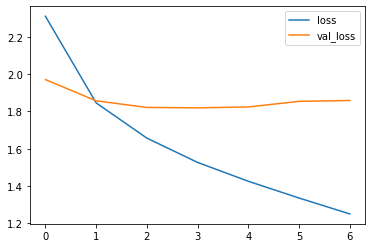

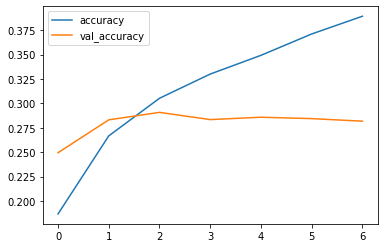

40/40 [==============================] - 245s 6s/step - loss: 1.2496 - accuracy: 0.3893 - val_loss: 1.8590 - val_accuracy: 0.2817


In [ ]:
if not PRODUCTION_MODE:
  epochs = 7 
  plot_losses = PlotLosses()
  checkpoint = ModelCheckpoint('/content/trans_seq2seq_trainable_TRUE-{epoch:03d}--{val_accuracy:03f}.h5',
                              verbose=1, monitor='val_loss',save_best_only=True,
                              save_weights_only=True, mode='min')

  transformer.compile(
      "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])



  transformer.fit(train_ds,
                  epochs=epochs,
                  validation_data=val_ds,
                  callbacks= [checkpoint,plot_losses])

In [ ]:
""" 40/40 [==============================]
- 245s 6s/step - 
loss: 1.2496 - accuracy: 0.3893 
val_loss: 1.8590 - val_accuracy: 0.2817
<keras.callbacks.History at 0x7f175a158dd0> """

In [ ]:
%cp '/content/trans_seq2seq_trainable_TRUE-004--0.283362.h5' '/content/drive/MyDrive/chatBot_momtazi/data/6'

# Trainable = FALSE

In [ ]:
embed_dim = embedding_dim
latent_dim = 2048
num_heads = 6

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim,emb_weights=enc_embed_weights,trainable_embed=False)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim,emb_weights=dec_embed_weights,trainable_embed=False)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_9 (Positi  (None, None, 300)   1812000     ['encoder_inputs[0][0]']         
 onalEmbedding)                                                                                   
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_4 (Transfo  (None, None, 300)   3398048     ['positional_embedding_

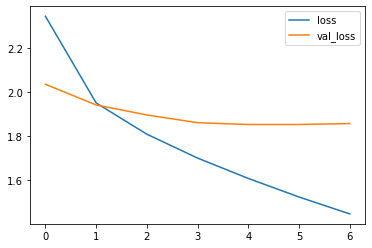

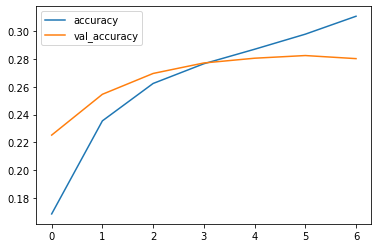

40/40 [==============================] - 225s 6s/step - loss: 1.4465 - accuracy: 0.3109 - val_loss: 1.8575 - val_accuracy: 0.2804


In [ ]:
if not PRODUCTION_MODE:
  epochs = 7 
  plot_losses = PlotLosses()
  checkpoint = ModelCheckpoint('/content/trans_seq2seq_trainable_FALSE-{epoch:03d}--{val_accuracy:03f}.h5',
                              verbose=1, monitor='val_loss',save_best_only=True,
                              save_weights_only=True, mode='min')


  transformer.compile(
      "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
  )
  transformer.fit(train_ds,
                  epochs=epochs,
                  validation_data=val_ds,
                  callbacks= [checkpoint,plot_losses])

In [ ]:
"""
40/40
225s 6s/step
loss: 1.8090 - accuracy: 0.2625
val_loss: 1.8965 - val_accuracy: 0.2697

Epoch 4/7
40/40 
225s 6s/step 
loss: 1.7004
accuracy: 0.2767
val_loss: 1.8614
val_accuracy: 0.2772

"""

In [ ]:
%cp '/content/trans_seq2seq_trainable_FALSE-005--0.280659.h5' '/content/drive/MyDrive/chatBot_momtazi/data/6'

# Trainable TRUE/FALSE Comparsion

Regarding 'per epoch time': trainable=true takes 245s per epoch while trainable=false takes slightly less time, 225s per epoch.

With respect to 'validation loss': trainable=true reaches 1.81 while trainable=false reaches 1.85. Hence, we should set trainable=true in our future experiments. 

'trainable=false', however, works better in terms of validation accuracy. But loss is more important than acc (ref: https://datascience.stackexchange.com/questions/37186/early-stopping-on-validation-loss-or-on-accuracy)

# Load the best model

In [43]:
if PRODUCTION_MODE:
  best_model_path = '/content/trans_seq2seq_trainable_TRUE-004--0.283362.h5'
  transformer.load_weights(best_model_path)

# Question 2

Finally, let's demonstrate how to reply to a conversation.
We simply feed into the model the vectorized input sentence
as well as the target token `"[start]"`, then we repeatedly generated the next token, until
we hit the token `"[end]"`.

In [44]:
out_vocab = dec_vectorization.get_vocabulary()
out_index_lookup = dict(zip(range(len(out_vocab)), out_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = enc_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = dec_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = out_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
          break
    return decoded_sentence


In [45]:
for i in range(5):
  user_txt = input("enter your text:")
  translated = decode_sequence(user_txt)
  print(user_txt)
  print(translated)
  print('***************')


enter your text:what do you do for your weekend ?
what do you do for your weekend ?
[start] i am very much . [end]
***************
enter your text:sir you look so silly 
sir you look so silly 
[start] i am very much . [end]
***************
enter your text:I am going to visit my friends now
I am going to visit my friends now
[start] i am not sure . [end]
***************
enter your text:how about you asking me a question . ask me the most difficult question that you know
how about you asking me a question . ask me the most difficult question that you know
[start] i am very much . [end]
***************
enter your text:so it seems you are always not sure
so it seems you are always not sure
[start] i am very much . [end]
***************
